In [23]:
import pandas as pd
import os
import numpy as np
import gspread
import glob
import seaborn as sns
from tqdm import tqdm


# Goal
1. For each city/state/country, we extract num_person_killed_lahk, daly at 2019
2. For each city, we extract daly at 2015 and 2019 for temporal analysis
3. For each city, we extract num_person_killed_lahk at 2016 section and 2019 section for temporal analysis
we test the relationship between presence of sidewalk per h3 level 6, 9, 12 index and dalys

* Note. Dependent variables are DALYs, num_person_killed_lahk (2019). India, US, Brazil, Hong Kong, Taipei should not use the WHO data. India (2018-2022 only); Brazil (2019 only). 

In [24]:
def load_all():
    serviceaccount = "../../google_drive_personal.json"
    import gspread

    # from oauth2client.service_account import ServiceAccountCredentials
    gc = gspread.service_account(filename=serviceaccount)


    def read_url(url, SHEET_NAME):
        SHEET_ID = url.split("/")[5]
        spreadsheet = gc.open_by_key(SHEET_ID)
        worksheet = spreadsheet.worksheet(SHEET_NAME)
        rows = worksheet.get_all_records()
        df_spread = pd.DataFrame(rows)
        return df_spread, worksheet


    url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
    SHEETNAME = "select_city_classifier"
    city_meta, other_worksheet = read_url(url, SHEETNAME)
    city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
    city_meta["city_lower"] = city_meta["City"].apply(lambda x: x.lower().replace(" ", ""))
    return city_meta

In [48]:
TRANS_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_transformed/"
TRANS_PATHS = {"dalys":"t_road_dalys/t_dalys_no_weight.csv", 
               "fatality":"t_road_fatality/t_fatality_country_state_county_year.csv"}


CURATED_FOLDER_CROSS = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_crossectional"
CURATED_FOLDER_LONG = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_longitudinal"
EXPORT_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_analysis"
if not os.path.exists(EXPORT_FOLDER):
    os.makedirs(EXPORT_FOLDER)
dalys = pd.read_csv(os.path.join(TRANS_FOLDER, TRANS_PATHS["dalys"]))
dalys["city_lower"] = dalys["city"].apply(lambda x: x.lower().replace(" ", ""))
fatality = pd.read_csv(os.path.join(TRANS_FOLDER, TRANS_PATHS["fatality"]))

In [26]:
h3_res = [6, 9, 12]
city_meta = load_all()

In [22]:
# Brazil Daly, can be used for other cases analysis later
# brazil_daly = \
# fatality[(fatality['country']=='Brazil')&(fatality["source"]!="WHO")&(fatality["state"]!="Brazil")].reset_index()[['state','year','DALY Rate']].rename(
#     columns = {'DALY Rate':'road_injury_cap'})
# brazil = \
# dalys[(dalys['country_clean']=='Brazil')&(dalys['year']==2019)][['city','city_clean','country_clean','urban_pop']]\
# .merge(city_meta[city_meta["Country"]=="Brazil"][["City","State/Province"]],
#        right_on = "City",
#        left_on = "city")\
# .merge(brazil_daly, right_on = "state", left_on = "State/Province").drop(["state", "City"], axis = 1)


,city,city_clean,country_clean,urban_pop,State/Province,year,road_injury_cap
0,Jequie,Jequie,Brazil,156126,Bahia,2019,959.0
1,Ilheus,Ilheus,Brazil,159923,Bahia,2019,959.0
2,Palmas,Palmas,Brazil,306296,Tocantins,2019,1527.0
3,Florianopolis,Florianopolis,Brazil,508826,Santa Catarina,2019,1272.0
4,Ribeirao Preto,Ribeirao Preto,Brazil,711825,Sao Paulo,2019,823.0
5,Sao Paulo,Sao Paulo,Brazil,12330000,Sao Paulo,2019,823.0
6,Curitiba,Curitiba,Brazil,1963726,Parana,2019,1293.0
7,Belo Horizonte,Belo Horizonte,Brazil,2722000,Minas Gerais,2019,1031.0
8,Rio de Janeiro,Rio de Janeiro,Brazil,6748000,Rio de Janeiro,2019,897.0


## 0. Process segmentation

In [ ]:
seg_problem_city = ["Nagoya", "Lima", "Rio de Janeiro","Dhaka"] # seg problems
pano_problem_city = ["Rome", "Dehli"]+seg_problem_city
pano_problem_city_lower = [x.lower().replace(" ", "") for x in pano_problem_city]

sely = ["country_clean",'urban_pop', 'pop_country', 'diabetes_mellitus_cap',
       'mental_and_substance_use_disorders_cap', 'cardiovascular_diseases_cap',
       'road_injury_cap', 'city_lower']
segfiles = glob.glob(CURATED_FOLDER_CROSS+"/*.parquet")
df_seg = []
for f in tqdm(segfiles):
    temp = pd.read_parquet(f)
    temp["city_lower"] = f.split("/")[-1].split(".")[0]
    df_seg.append(temp)
df_seg = pd.concat(df_seg).reset_index(drop = True)

# df_seg = df_seg[~df_seg["city_lower"].isin(pano_problem_city_lower)].reset_index(drop = True)
# df_seg.head()

In [86]:
segfiles = glob.glob(CURATED_FOLDER_LONG+"/*.parquet")
df_seg_long = []
for f in tqdm(segfiles):
    temp = pd.read_parquet(f)
    temp["city_lower"] = f.split("/")[-1].split(".")[0]
    df_seg_long.append(temp)
df_seg_long = pd.concat(df_seg_long).reset_index(drop = True)

100%|██████████| 127/127 [00:22<00:00,  5.73it/s]


In [ ]:
# count number of people, car, furniture using the pano file



## 1. Generate DALY data crossectional first 

In [28]:
dalys['year'].unique() # change the 2015 to 2016 for the dalys estimation so that the data can map
year_group1 = [2015,2016,2017,2018]
year_group2 = [2019, 2020, 2021, 2022]
fatality_sel_year = [2016,2019]
# since DALY only has till 2019 data
# fatality, select the 2016 and 2019, world data only availiable till 2019

In [ ]:
seg_sample = df_seg\
            .merge(dalys[sely], on = 'city_lower')
print(seg_sample["city_lower"].nunique(), " cities processed.")

yls = ['diabetes_mellitus_cap',
       'mental_and_substance_use_disorders_cap', 'cardiovascular_diseases_cap',
       'road_injury_cap']
xls = ['building', 'greenery', 'street_furniture',
       'sidewalk', 'car', 'person', 'bike', 'sky', 'road']
logxls = ["log_"+x for x in xls]
logyls = ["log_"+x for x in yls]
for x in xls+yls:
    seg_sample["log_"+x] = np.log(seg_sample[x]+1)

<Axes: xlabel='sidewalk', ylabel='road_injury_cap'>

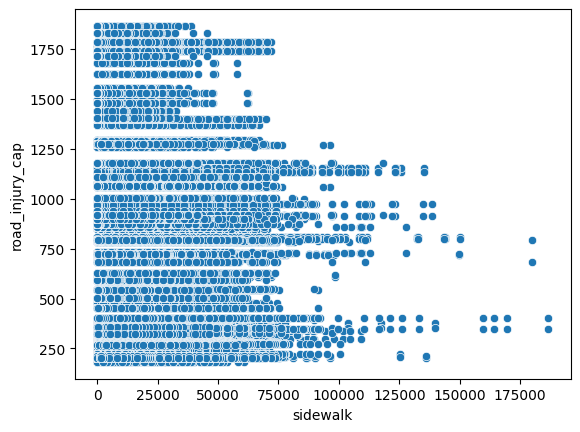

In [39]:
sns.scatterplot(
    data = seg_sample[seg_sample["res"]==12],
    x = "sidewalk",
    y = "road_injury_cap",
    # hue = "Country"
)

In [40]:
seg_sample[seg_sample["res"].isin([6,9])].to_csv(os.path.join(EXPORT_FOLDER, "01_seg_dalys_cross.csv"), index = False)

In [75]:
seg_sample[seg_sample["res"].isin([6,9])].shape

(642341, 33)

## 2. Analyze the fatality (number person killed by 100_000 population)
### 2.a Match years

In [97]:
fatality_19 = fatality[fatality['year'].isin([2019,2020,2021,2022])].reset_index(drop = True)
fatality_19['year_group'] = '2020-2023'
fatality_16 = fatality[fatality['year'].isin([2014, 2015,2016, 2017])].reset_index(drop = True)
fatality_16['year_group'] = '2015-2018'
fatality_16['City'].nunique()

118

In [98]:
fatality_long = pd.concat([fatality_19, fatality_16]).reset_index(drop = True)

In [101]:
sely_fatality = ['num_person_killed_per_lakh', 'num_person_killed']
seg_sample_fatality = df_seg_long\
            .merge(fatality_long[sely_fatality+["city_lower","year_group"]], on = ['city_lower', 'year_group'])
print(seg_sample_fatality.groupby("year_group")["city_lower"].nunique(), " cities processed.")


year_group
2015-2018    106
2020-2023    118
Name: city_lower, dtype: int64  cities processed.


/home/yuanzf/.local/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35')])

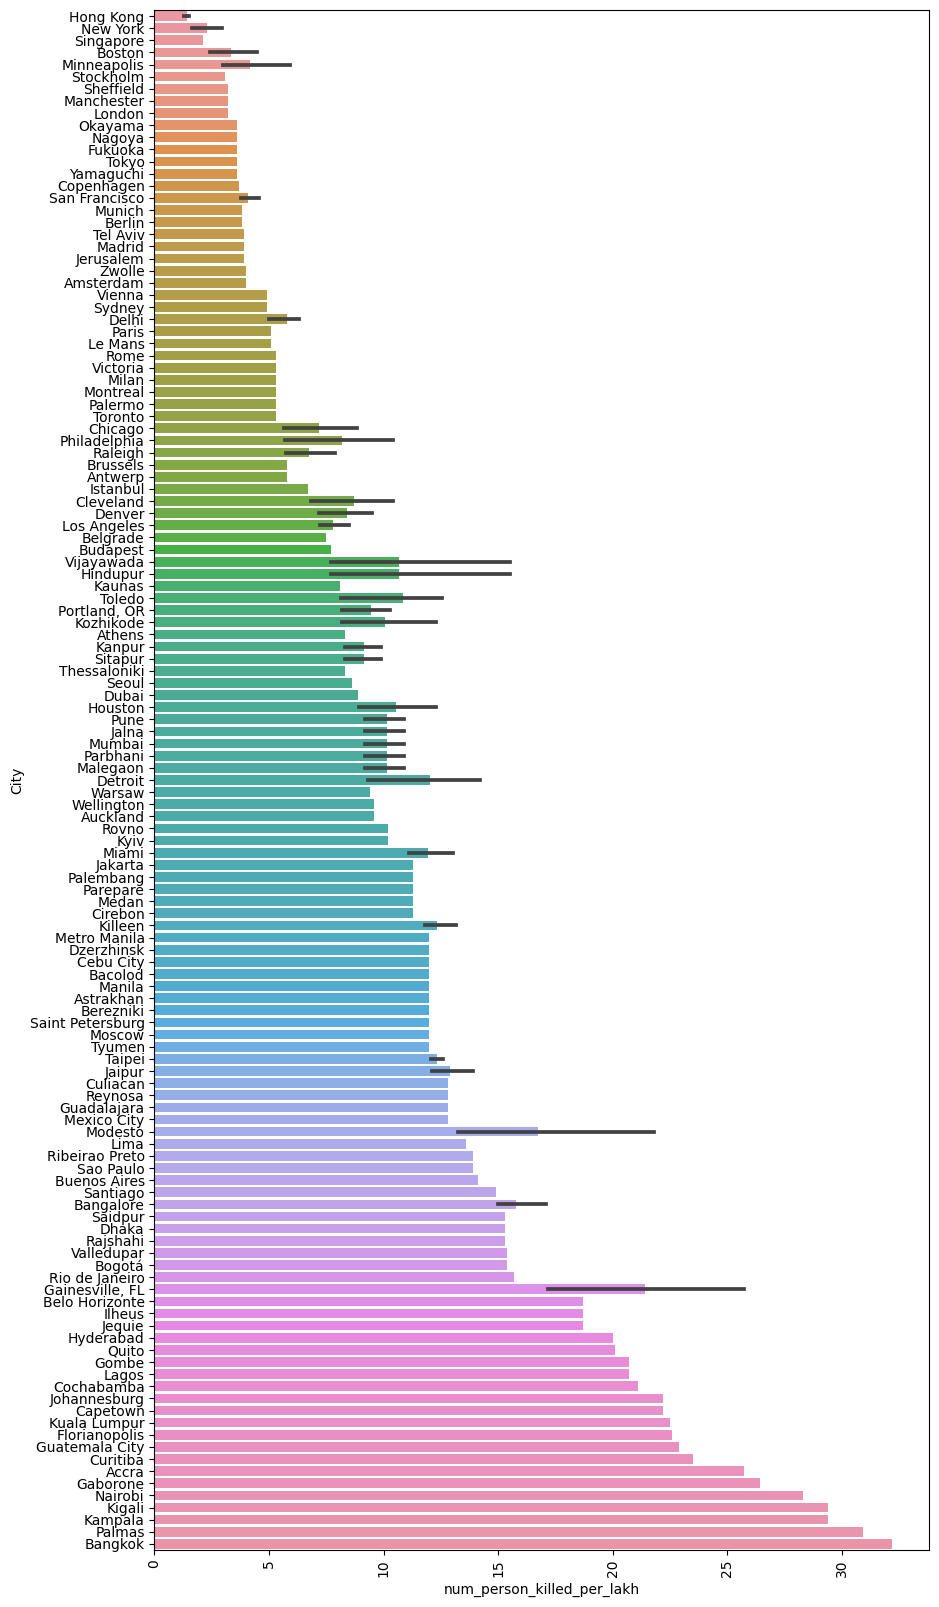

In [73]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,20))
sns.barplot(
    data = fatality_19.sort_values("num_person_killed_per_lakh"),
    y = "City",
    x = "num_person_killed_per_lakh"
)
plt.xticks(rotation=90)

<Axes: xlabel='sidewalk', ylabel='num_person_killed_per_lakh'>

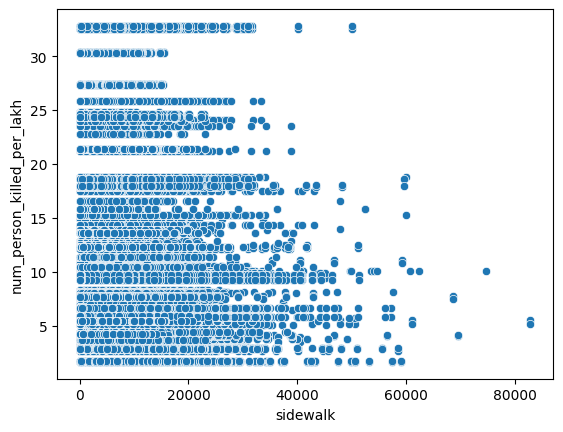

In [95]:
sns.scatterplot(
    data = seg_sample_fatality_16[(seg_sample_fatality_16["res"]==9)],
    x = "sidewalk",
    y = "num_person_killed_per_lakh",
    # hue = "Country"
)

<Axes: xlabel='sidewalk', ylabel='num_person_killed_per_lakh'>

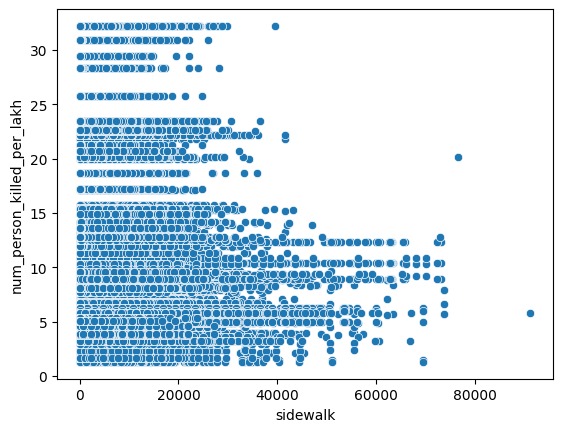

In [96]:
sns.scatterplot(
    data = seg_sample_fatality[(seg_sample_fatality["res"]==9)],
    x = "sidewalk",
    y = "num_person_killed_per_lakh",
    # hue = "Country"
)

<Axes: xlabel='sidewalk', ylabel='num_person_killed_per_lakh'>

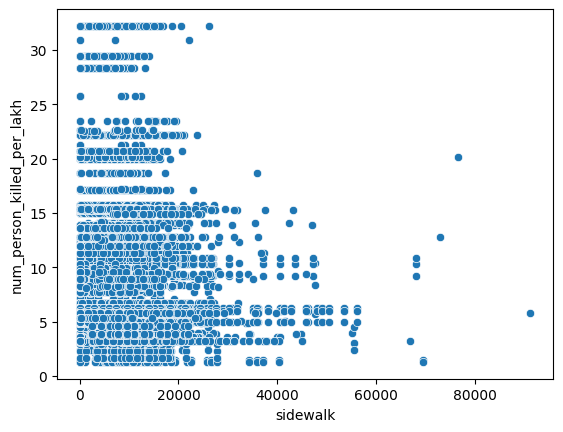

In [92]:
sns.scatterplot(
    data = seg_sample_fatality[(seg_sample_fatality["res"]==9)&(seg_sample_fatality["person"]>500)],
    x = "sidewalk",
    y = "num_person_killed_per_lakh",
    # hue = "Country"
)